<a href="https://colab.research.google.com/github/finardi/WatSpeed_LLM_foundation/blob/main/Module4%3A%20Distillation_(BERT_%3E_miniLM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 4 - Distillation (BERT -> miniLM)

In this notebook, we present an example of how to use distillation in a document classification task. We will finetune a smaller "student" model on the predictions made be a larger "teacher" model.

Our dataset will be a smaller version of the [IMDB Sentiment Analysis](https://ai.stanford.edu/~amaas/data/sentiment/) dataset.

Our teacher model will be a [BERT-base](https://huggingface.co/google/bert_uncased_L-12_H-768_A-12) model with 110M parameters and our student will be a [miniLM](nreimers/MiniLM-L6-H384-uncased) model with 22M parameters.

We first finetune the teacher using the cross-entropy loss and "hard" labels, i.e., true/false labels annotated by humans.

Then we finetune the student using the mean-squared-error (MSE) loss using the logits predicted by the teacher as our target.

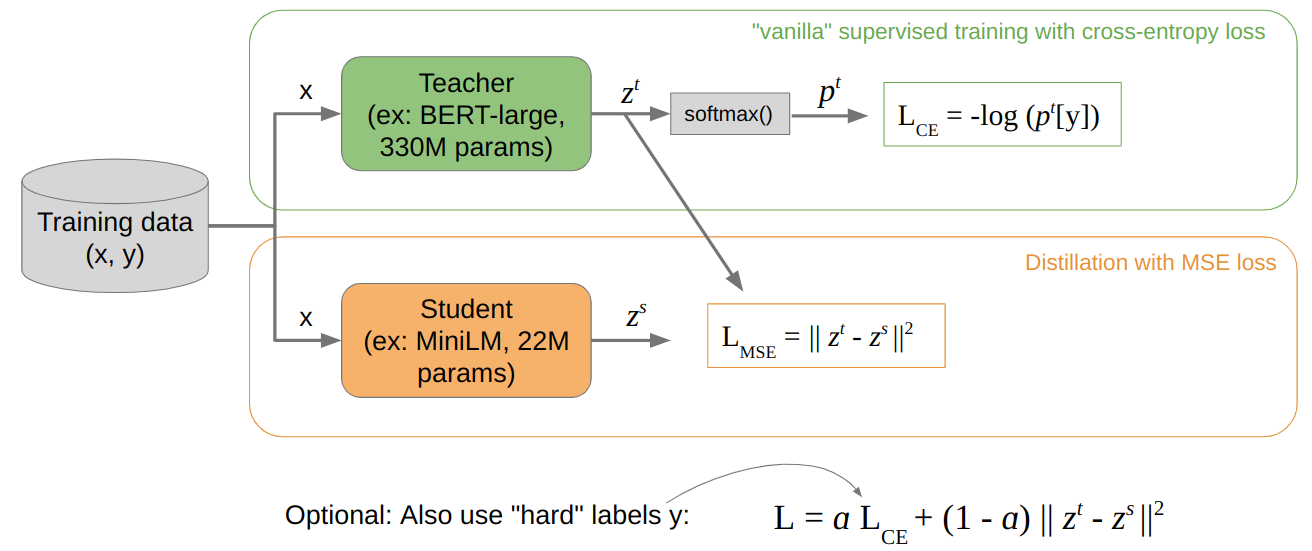

# Installing required packages

In this example, we have to install  `transformers` library from Hugging Face. [Hugging Face](https://huggingface.co/) is an AI startup that has gained significant traction in the NLP community recently. It provides a suite of open-source tools and libraries, making it easy for developers and researchers to work with state-of-the-art NLP models.

**`transformers`**:

Transformers is an open-source library for NLP developed by Hugging Face. It provides state-of-the-art pre-trained models for various NLP tasks, such as text classification, sentiment analysis, question-answering, named entity recognition, etc. The library is built on top of PyTorch and TensorFlow and provides easy-to-use interfaces to access pre-trained models and fine-tune them on specific tasks. The library also provides tools for training custom models and sharing them with the community.

In [ ]:
!pip install transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.4 MB/s eta 0:00:00


# Setting the device

In this example, we will use a GPU to speed up the processing of our model. GPUs (Graphics Processing Units) are specialized processors that are optimized for performing large-scale computations in parallel. By using a GPU, we can accelerate the training and inference of a machine learning model, which can significantly reduce the time required to complete these tasks.

Before we begin, we need to check whether a GPU is available and select it as the default device for our PyTorch operations. This is because PyTorch can use either a CPU or a GPU to perform computations, and by default, it will use the CPU. 

For using a GPU in Google Colab: 
1. Click on the "Runtime" menu at the top of the screen.
2. From the dropdown menu, click on "Change runtime type".
3. In the popup window that appears, select "GPU" as the hardware accelerator.
4. Click on the "Save" button.

That's it! Now you can use the GPU for faster computations in your notebook. 

In [ ]:
!nvidia-smi

Sun May 21 23:22:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch

if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


# Setting random seed

Setting the random seed ensures reproducibility in random number generation. When you set a random seed, it initializes the random number generator with a fixed starting point, so that subsequent random operations will produce the same sequence of random numbers each time the code is run with the same seed.

Here's a breakdown of what each line does:

1. `random.seed(123)`: Sets the random seed for the `random` module in Python's standard library. This affects functions like `random.random()` and `random.shuffle()`.

2. `np.random.seed(123)`: Sets the random seed for the `numpy` library. This affects functions like `numpy.random.rand()` and `numpy.random.shuffle()`.

3. `torch.manual_seed(123)`: Sets the random seed for the `torch` library. This affects functions like `torch.randn()` and random initialization of tensors.

By setting the same seed value (123 in this case) for all three libraries, you ensure that any random operations performed using these libraries within your code will generate the same results each time the code is run with the same seed. This is useful for reproducibility, especially when working with models that involve randomness, such as neural networks that use random initialization or data shuffling.

In [ ]:
import random
import torch
import torch.nn.functional as F
import numpy as np

random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

# Loading teacher model

In the provided code, we load the BERT-base model, which will be used as the teacher model. The specific model being loaded is **`google/bert_uncased_L-12_H-768_A-12`**.

In this code, we import the **`AutoTokenizer`** and **`AutoModelForSequenceClassification`** classes from the Hugging Face transformers library. These classes enable us to load and use pre-trained models.



In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

teacher_name = 'google/bert_uncased_L-12_H-768_A-12'
teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_name)

# Preparing the data

First, we download the dataset. In this notebook, we will be using the IMDB dataset, which consists of movie reviews labeled as positive or negative sentiment. To download the dataset, we can run the commands below.

The first command, `wget`, is used to download the dataset file `aclImdb.tgz`. The `-nc` flag ensures that the file is not re-downloaded if it already exists in the current directory.

The second command, `tar`, is used to extract the contents of the `aclImdb.tgz` file. This will create a directory named `aclImdb` containing the dataset files.

In [ ]:
!wget -nc http://files.fast.ai/data/aclImdb.tgz 
!tar -xzf aclImdb.tgz

--2023-05-21 23:22:44--  http://files.fast.ai/data/aclImdb.tgz
Resolving files.fast.ai (files.fast.ai)... 104.26.3.19, 172.67.69.159, 104.26.2.19, ...
Connecting to files.fast.ai (files.fast.ai)|104.26.3.19|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.fast.ai/data/aclImdb.tgz [following]
--2023-05-21 23:22:44--  https://files.fast.ai/data/aclImdb.tgz
Connecting to files.fast.ai (files.fast.ai)|104.26.3.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145982645 (139M) [application/x-gtar-compressed]
Saving to: ‘aclImdb.tgz’

aclImdb.tgz         100%[===================>] 139.22M  55.0MB/s    in 2.5s    

2023-05-21 23:22:47 (55.0 MB/s) - ‘aclImdb.tgz’ saved [145982645/145982645]



## Loading the dataset

The IMDB dataset has 25,000 training + 25,000 test examples, but we will use only 1,000 for training, 1,000 for validation and another 1,000 for test.

In [ ]:
max_train = 1000
max_valid = 1000
max_test = 1000

The function **`load_texts(folder)`** is defined to read and load the text data from the specified **`folder`**.


In [ ]:
import os

def load_texts(folder):
    texts = []
    for path in os.listdir(folder):
        with open(os.path.join(folder, path)) as f:
            texts.append(f.read())
    return texts

The positive and negative training reviews are loaded separately from the respective folders **`'aclImdb/train/pos'`** and **`'aclImdb/train/neg'`** using the **`load_texts()`** function. Similarly, the positive and negative test reviews are loaded from the folders **`'aclImdb/test/pos'`** and **`'aclImdb/test/neg'`**.

In [ ]:
x_train_pos = load_texts('aclImdb/train/pos')
x_train_neg = load_texts('aclImdb/train/neg')
x_test_pos = load_texts('aclImdb/test/pos')
x_test_neg = load_texts('aclImdb/test/neg')

The loaded training and test reviews are combined into separate lists: **`x_train`** for training reviews and **`x_test`** for test reviews.

In [ ]:
x_train = x_train_pos + x_train_neg
x_test = x_test_pos + x_test_neg

The corresponding labels for the reviews are created: **`y_train`** for training labels and **`y_test`** for test labels. Positive reviews are assigned the label 1, and negative reviews are assigned the label 0.

In [ ]:
y_train = [1] * len(x_train_pos) + [0] * len(x_train_neg)
y_test = [1] * len(x_test_pos) + [0] * len(x_test_neg)

The training and test sets are shuffled by zipping the reviews and labels, shuffling them randomly, and then unzipping them to separate the shuffled reviews and labels.

In [ ]:
c = list(zip(x_train, y_train))
random.shuffle(c)
x_train, y_train = list(zip(*c))

# Now shuffle the test set.
c = list(zip(x_test, y_test))
random.shuffle(c)
x_test, y_test = list(zip(*c))

An assertion is made to ensure that the sum of **`max_valid`** (number of validation examples) and **`max_train`** (number of training examples) is less than the total number of training examples available.

In [ ]:
assert max_valid + max_train < len(x_train)

The datasets are created by selecting the last max_valid reviews and labels from the shuffled sets.


In [ ]:
x_valid = list(x_train[-max_valid:])
y_valid = list(y_train[-max_valid:])
x_train = list(x_train[:max_train])
y_train = list(y_train[:max_train])
x_test = list(x_test[:max_test])
y_test = list(y_test[:max_test])

The lengths of the training, validation, and test sets are printed to confirm the number of examples in each set.

In [ ]:
print(len(x_train), 'training examples.')
print(len(x_valid), 'valid examples.')
print(len(x_test), 'test examples.')

1000 training examples.
1000 valid examples.
1000 test examples.


The first 3 examples from the training, validation, and test sets are printed, showing the corresponding label (y) and the first 100 characters of the review (x).

In [ ]:
print('\nFirst 3 training examples:')
for x, y in zip(x_train[:3], y_train[:3]):
    print(y, x[:100])

print(100 * '-' + '\nFirst 3 validation examples:')
for x, y in zip(x_valid[:3], y_valid[:3]):
    print(y, x[:100])

print(100 * '-' + '\nFirst 3 test examples:')
for x, y in zip(x_test[:3], y_test[:3]):
    print(y, x[:100])


First 3 training examples:
0 The most embarrassing moment in this film is when Brady Corbet says 'You've blossomed', near the end
0 I've been trying to track down this film just by googling bad phrases about "teenagers seduce and ki
1 This light hearted comedy should be enjoyed for entertainment value. It gets quite hysterically funn
----------------------------------------------------------------------------------------------------
First 3 validation examples:
0 Before I'd seen this, I had seen some pretty bad Christmas films. But once I saw this, "Jingle All t
1 My observations: Postwar hilarity. Tom Drake and Grandpa from "Meet Me in St. Louis" two years later
1 The pilot is extremely well done. It lays out how the characters bond in future episodes. I don't th
----------------------------------------------------------------------------------------------------
First 3 test examples:
0 I gave this movie a chance only because it had very good reviews. After seeing the trailer I thoug

## Computing input lengths

In order to understand the length distribution of input tokens, we compute the mean and standard deviation of token lengths for a subset of the training data.

In this code, we use the teacher's tokenizer, `teacher_tokenizer`, to tokenize a subset of the training data, specifically the first 1,000 examples (`x_train[:1_000]`). The tokenizer's `__call__` method tokenizes the input text and returns a dictionary of tokenization outputs, including the `input_ids` which represent the tokenized sequence.

We iterate over the tokenized sequences and compute the length of each sequence using the `len()` function. The lengths are stored in the `lengths` list.

Finally, we use the `mean()` and `stdev()` functions from the `statistics` module to calculate the mean and standard deviation of the token lengths, respectively. The results are printed, providing insights into the average and variation in token lengths within the subset of training data.

By executing these lines of code, we obtain the mean and standard deviation of token lengths, which can help us understand the distribution and variability of input lengths in the training data.

In [ ]:
from statistics import mean, stdev

lengths = [len(tokens) for tokens in teacher_tokenizer(x_train[:1_000])['input_ids']]
print(f'Mean length in tokens: {mean(lengths):0.2f}')
print(f'Stdev length in tokens: {stdev(lengths):0.2f}')

Mean length in tokens: 313.06
Stdev length in tokens: 231.28


## Converting to PyTorch's Dataset/Dataloader

To efficiently feed data to train our model, we use the `Dataset` and `DataLoader` classes provided by PyTorch. The `Dataset` class allows us to randomly access training examples, while the `DataLoader` class packs examples into batches.

First, we tokenize the input sequences using the teacher's tokenizer and convert them into PyTorch tensors. We set the maximum length of the tokenized sequences to 300, and enable truncation to ensure that all sequences fit within this limit.

The code snippet for converting the data to PyTorch's Dataset format is as follows:


In this code, we use the `teacher_tokenizer` to tokenize the training, validation, and test sets. We pass the `x_train`, `x_valid`, and `x_test` sequences to the tokenizer along with the specified `max_length` and `truncation=True` parameters.

The tokenizer performs tokenization on the input sequences and returns a dictionary of tokenization outputs. Each dictionary includes the `input_ids`, `attention_mask`, and other relevant information.

The resulting tokenized sequences, `x_train_tokenized`, `x_valid_tokenized`, and `x_test_tokenized`, contain the tokenized representations of the input sequences, ready to be used in the next steps of training the model.

In [ ]:
max_length = 300
x_train_tokenized = teacher_tokenizer(x_train, max_length=max_length, truncation=True)
x_valid_tokenized = teacher_tokenizer(x_valid, max_length=max_length, truncation=True)
x_test_tokenized = teacher_tokenizer(x_test, max_length=max_length, truncation=True)

In following code, we define a custom `Dataset` class that inherits from PyTorch's `data.Dataset` class. This custom dataset class allows us to organize and access our tokenized examples and corresponding targets.

The `__init__` method initializes the dataset by storing the tokenized examples and targets provided as arguments.

The `__len__` method returns the length of the dataset, which is the number of examples in the `input_ids` list.

The `__getitem__` method allows us to retrieve a specific example and its corresponding target at a given index `idx`. It returns a dictionary containing the `input_ids`, `attention_mask`, and `labels` for the example at the specified index.

By defining this custom `Dataset` class, we can easily access individual examples and their targets during training, validation, and testing stages using the PyTorch `DataLoader` class.

In [ ]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, examples, targets):
        self.examples = examples
        self.targets = targets
    
    def __len__(self):
        return len(self.examples['input_ids'])
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.examples['input_ids'][idx],
            'attention_mask': self.examples['attention_mask'][idx],
            'labels': self.targets[idx],
        }

In following code, we create instances of the `Dataset` class for the training, validation, and test sets. We pass the tokenized examples (`x_train_tokenized`, `x_valid_tokenized`, `x_test_tokenized`) and their corresponding targets (`y_train`, `y_valid`, `y_test`) as arguments to initialize the datasets.

By creating these dataset objects, we have organized our tokenized examples and targets in a format that can be easily used by PyTorch's `DataLoader` class for efficient batching and loading during training and evaluation.

In [ ]:
dataset_train = Dataset(x_train_tokenized, y_train)
dataset_valid = Dataset(x_valid_tokenized, y_valid)
dataset_test = Dataset(x_test_tokenized, y_test)

In this code snippet, we define a collate function `teacher_collate_fn` that takes a batch of examples as input. The function uses the `teacher_tokenizer` to pad the examples in the batch with "pad" tokens so that they all have the same length. This is necessary because the input to the BERT model needs to have consistent dimensions.

The `teacher_collate_fn` returns a `BatchEncoding` object that contains the padded batch of examples, ready to be processed by the model. The `return_tensors='pt'` argument ensures that the output is in PyTorch tensors format.

This collate function will be used by the `DataLoader` to collate the individual examples into batches during training or evaluation.

In [ ]:
from transformers import BatchEncoding

# This functions adds "pad" tokens to examples in the batch that are shorter than the largest one.
def teacher_collate_fn(batch):
  return BatchEncoding(teacher_tokenizer.pad(batch, return_tensors='pt'))

In the code below, we create PyTorch's `DataLoader` objects for the training, validation, and test datasets. The `DataLoader` allows us to efficiently iterate over the dataset in batches during training and evaluation.

- `dataloader_train` is the `DataLoader` for the training dataset. It loads the examples in batches of size 32 and shuffles the examples randomly at the start of each epoch (`shuffle=True`). The `collate_fn` argument is set to `teacher_collate_fn`, which is the function we defined earlier to pad the examples in the batch.

- `dataloader_valid` is the `DataLoader` for the validation dataset. It also loads the examples in batches of size 32, but does not shuffle the examples (`shuffle=False`).

- `dataloader_test` is the `DataLoader` for the test dataset. Similar to the validation dataloader, it loads the examples in batches of size 32 and does not shuffle the examples.

These dataloaders will be used to iterate over the datasets during the training and evaluation processes.

In [ ]:
# Convert examples to Pytorch's DataLoader.
dataloader_train = data.DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn=teacher_collate_fn)
dataloader_valid = data.DataLoader(dataset_valid, batch_size=32, shuffle=False, collate_fn=teacher_collate_fn)
dataloader_test = data.DataLoader(dataset_test, batch_size=32, shuffle=False, collate_fn=teacher_collate_fn)

# Finetuning the Teacher Model

Finetuning a BERT-base model for one epoch (1,000 examples) should take ~1 minute on a T4 or P100 GPU.

First, we define the evaluation function to measure accuracy and loss. The function **`evaluate()`** takes the model (in our case, the teacher model), the dataloader for a specific dataset (train, valid, or test), and the set_name to identify the dataset. It initializes empty lists for losses and a variable to count the number of correct predictions. The model is set to evaluation mode using **`model.eval()`**. Then, for each batch in the dataloader, the model performs forward pass on the batch, calculates the loss, appends it to the list of losses, and determines the predictions by selecting the class with the highest logits. The function also keeps track of the number of correct predictions. Finally, it prints the average loss and accuracy for the dataset.







In [ ]:
# We first define the evaluation function to measure accuracy and loss
def evaluate(model, dataloader, set_name):
    losses = []
    correct = 0
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, mininterval=0.5, desc=set_name, disable=False):
            outputs = model(**batch.to(device))
            loss_val = outputs.loss
            losses.append(loss_val.cpu().item())
            preds = outputs.logits.argmax(dim=1)
            correct += (preds == batch['labels']).sum().item()

    print(f'{set_name} loss: {mean(losses):0.3f}; {set_name} accuracy: {correct / len(dataloader.dataset):0.3f}')

In the following code, we define the necessary components for finetuning the teacher model. We set the device to either GPU (if available) or CPU. The teacher model is loaded using `AutoModelForSequenceClassification` and moved to the specified device.

We specify the number of epochs for training (5 in this case) and define the optimizer as AdamW with a learning rate of 5e-5. The number of training steps is calculated based on the number of epochs and the length of the training dataloader. We also set the number of warmup steps, which is 10% of the total training steps. The scheduler is created using `get_linear_schedule_with_warmup` with the optimizer, warmup steps, and total training steps.

Before starting the training loop, we perform an initial evaluation on the validation dataset using the `evaluate` function to check if the evaluation code is working correctly.

Inside the training loop, we iterate over the epochs using `tqdm`. The model is set to train mode using `model.train()`. We initialize an empty list to store the training losses for each batch. For each batch in the training dataloader, we zero the gradients of the optimizer, perform the forward pass on the batch, calculate the loss, perform backpropagation, update the optimizer parameters, and update the scheduler. The training loss for the batch is appended to the list of training losses.

After each epoch, we print the epoch number and the average training loss. We then perform evaluation on the validation dataset using the `evaluate` function. This provides an indication of the model's performance on unseen data during the training process.

In [ ]:
from torch import nn
from torch import optim
from tqdm.auto import tqdm
from transformers import get_linear_schedule_with_warmup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForSequenceClassification.from_pretrained(teacher_name).to(device)
print('Parameters', model.num_parameters())

epochs = 5
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
num_training_steps = epochs * len(dataloader_train)
# Warm up is important to stabilize training.
num_warmup_steps = int(num_training_steps * 0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

# First validation to check if evaluation code is working and accuracy is random as expected 
evaluate(model=model, dataloader=dataloader_valid, set_name='Valid')

# Training loop
for epoch in tqdm(range(epochs), desc='Epochs'):
    model.train()
    train_losses = []
    for batch in tqdm(dataloader_train, mininterval=0.5, desc='Train', disable=False):
        optimizer.zero_grad()
        outputs = model(**batch.to(device))
        loss = outputs.loss  # By default, HF uses the cross-entropy loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_losses.append(loss.cpu().item())

    print(f'Epoch: {epoch + 1} Training loss: {mean(train_losses):0.2f}')
    evaluate(model=model, dataloader=dataloader_valid, set_name='Valid')

Some weights of the model checkpoint at google/bert_uncased_L-12_H-768_A-12 were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification

Parameters 109483778


Valid:   0%|          | 0/32 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Valid loss: 0.702; Valid accuracy: 0.505


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1 Training loss: 0.54


Valid:   0%|          | 0/32 [00:00<?, ?it/s]

Valid loss: 0.408; Valid accuracy: 0.847


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 2 Training loss: 0.27


Valid:   0%|          | 0/32 [00:00<?, ?it/s]

Valid loss: 0.279; Valid accuracy: 0.894


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 3 Training loss: 0.14


Valid:   0%|          | 0/32 [00:00<?, ?it/s]

Valid loss: 0.316; Valid accuracy: 0.901


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 4 Training loss: 0.06


Valid:   0%|          | 0/32 [00:00<?, ?it/s]

Valid loss: 0.349; Valid accuracy: 0.891


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 5 Training loss: 0.03


Valid:   0%|          | 0/32 [00:00<?, ?it/s]

Valid loss: 0.346; Valid accuracy: 0.896


# Collecting Student's "labels" from the teacher

In this code, we collect the student's "labels" from the teacher model. 

We create an empty list `y_train_student` to store the labels.

We create a new dataloader `dataloader_train` with a batch size of 16. This dataloader will iterate over the training dataset and use the `teacher_collate_fn` function to collate the batches.

We iterate over the batches in the `dataloader_train` using `tqdm` to show the progress. For each batch, we pass the input IDs and attention masks to the teacher model. The model generates logits, which are probabilities assigned to each class. We convert the logits to a list using `.tolist()` and extend the `y_train_student` list with the logits.

At the end of this code, the `y_train_student` list will contain the logits generated by the teacher model for each training example. These logits will be used as pseudo-labels for the student model during knowledge distillation.

In [ ]:
y_train_student = []

dataloader_train = data.DataLoader(dataset_train, batch_size=16, shuffle=False, collate_fn=teacher_collate_fn)

for batch in tqdm(dataloader_train, mininterval=0.5, desc='Collecting labels', disable=False):
    outputs = model(batch['input_ids'].to(device), attention_mask=batch['attention_mask'].to(device))
    logits = outputs.logits.tolist()
    y_train_student.extend(logits)

Let's inspect the logits of the 3 first examples

In [ ]:
print(y_train_student[:3])

[[2.955475330352783, -2.845261812210083], [2.855618476867676, -2.6248559951782227], [-2.496201515197754, 2.6036674976348877]]


# Reprocessing the dataset for the Student

In this section, we will reprocess the dataset for the student model and prepare it for knowledge distillation. Knowledge distillation is a technique used to transfer knowledge from a larger, more powerful model (teacher) to a smaller, more efficient model (student). The student model learns not only from the ground truth labels but also from the predictions of the teacher model.

First, we will load the student model using the code below. we specify the name of the student model as **`"nreimers/MiniLM-L6-H384-uncased"`** and create a tokenizer object student_tokenizer using **`AutoTokenizer.from_pretrained()`**. The student model is a smaller variant of BERT called MiniLM-L6 with a hidden size of 384 and uncased (lowercase) tokens.

By loading the student model, we will be able to reprocess the dataset and prepare it for training the student model with knowledge distillation.

In [ ]:
student_name = "nreimers/MiniLM-L6-H384-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_name)

Then, we need to tokenize the dataset again because the student model uses a different tokenizer. We will use the student_tokenizer to tokenize the examples. The maximum length of the tokens will be set to 300, and any examples longer than this will be truncated.


In the code below, we use the student_tokenizer to tokenize the training, validation, and test examples. The **`max_length`** parameter specifies the maximum length of the tokens, and the **`truncation`** parameter ensures that any examples longer than max_length are truncated. The tokenized datasets will be used for training the student model with knowledge distillation.


In [ ]:
# We need to tokenize the dataset again because the student uses a diferent tokenizer
max_length = 300
x_train_tokenized = student_tokenizer(x_train, max_length=max_length, truncation=True)
x_valid_tokenized = student_tokenizer(x_valid, max_length=max_length, truncation=True)
x_test_tokenized = student_tokenizer(x_test, max_length=max_length, truncation=True)

Now, we need to convert the tokenized examples into PyTorch's Dataset format. This allows us to efficiently feed the data to train our student model with knowledge distillation.

In the code below, we create instances of the **`Dataset`** class for the training, validation, and test datasets. These datasets consist of the tokenized examples and the corresponding predicted labels from the teacher model (**`y_train_student`**). These datasets will be used to train and evaluate the student model with knowledge distillation.






In [ ]:
# Convert examples to Pytorch's Dataset.
dataset_train = Dataset(x_train_tokenized, y_train_student)
dataset_valid = Dataset(x_valid_tokenized, y_valid)
dataset_test = Dataset(x_test_tokenized, y_test)

Now, we need to define a collate function for the student model, which adds "pad" tokens to examples in a batch that are shorter than the largest one. This ensures that all examples in a batch have the same length for efficient processing.

In the code below, the **`student_collate_fn`** function takes a batch of examples and applies padding using the student tokenizer. The examples are then returned as a **`BatchEncoding`** object.

In [ ]:
# This functions adds "pad" tokens to examples in the batch that are shorter than the largest one.
def student_collate_fn(batch):
  return BatchEncoding(student_tokenizer.pad(batch, return_tensors='pt'))

Finally, we convert the tokenized examples into PyTorch's DataLoader, which allows us to iterate over the data in batches during training and evaluation.

In the code below, we create instances of the **`DataLoader`** class for the training, validation, and test datasets. The **`batch_size`** parameter determines the number of examples in each batch, and **`shuffle=True`** for the training dataloader ensures that the examples are randomly shuffled before each epoch. The collate_fn parameter is set to our **`student_collate_fn`** function, which applies padding to the examples in each batch.



In [ ]:
# Convert examples to Pytorch's DataLoader.
dataloader_train = data.DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn=student_collate_fn)
dataloader_valid = data.DataLoader(dataset_valid, batch_size=32, shuffle=False, collate_fn=student_collate_fn)
dataloader_test = data.DataLoader(dataset_test, batch_size=32, shuffle=False, collate_fn=student_collate_fn)

# Finetuning the Student Model

In this section, we will describe the process of fine-tuning the student model using knowledge distillation. The student model is initialized with the pre-trained weights of the chosen student model architecture. We will use the MiniLM model in this example.

In the code above, we initialize the student model using the **`AutoModelForSequenceClassification`** class from the Hugging Face library. The **`from_pretrained`** method loads the pre-trained weights of the student model specified by **`student_name`**. We move the model to the available device (GPU if available) using **`to(device)`**. We also print the number of parameters in the model.

We set the number of training epochs to 5 and define the optimizer as AdamW with a learning rate of 1e-4. The total number of training steps is calculated by multiplying the number of epochs with the number of batches in the training dataloader. We also specify the number of warm-up steps for the learning rate scheduler.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForSequenceClassification.from_pretrained(student_name).to(device)
print('Parameters', model.num_parameters())

epochs = 5
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
num_training_steps = epochs * len(dataloader_train)
# Warm up is important to stabilize training.
num_warmup_steps = int(num_training_steps * 0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nreimers/MiniLM-L6-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameters 22713986


Next, we perform an initial evaluation of the student model on the validation set to check if the evaluation code is working correctly and to establish a baseline accuracy.

Inside the training loop, we set the student model to training mode using **`model.train()`**. We iterate over the batches in the training dataloader and perform the following steps:
- Zero the gradients of the optimizer using **`optimizer.zero_grad()`**.
- Forward pass the batch through the student model and obtain the logits.
- Move the ground truth labels to the device and calculate the mean squared error (MSE) loss between the logits and the labels.
- Backpropagate the gradients and update the model parameters using **`optimizer.step()`**.
- Adjust the learning rate schedule using **`scheduler.step()`**.
- Append the training loss of the batch to the **`train_losses`** list.

After each epoch, we print the average training loss and perform an evaluation of the student model on the validation set using the **`evaluate`** function.

By the end of the training loop, the student model will be fine-tuned using knowledge distillation, and its performance can be evaluated on the test set using the **`evaluate`** function.

In [ ]:
for epoch in tqdm(range(epochs), desc='Epochs'):
    model.train()
    train_losses = []
    for batch in tqdm(dataloader_train, mininterval=0.5, desc='Train', disable=False):
        optimizer.zero_grad()
        outputs = model(input_ids=batch['input_ids'].to(device), attention_mask=batch['attention_mask'].to(device))
        logits = outputs.logits
        y = batch['labels'].to(device)
        loss = ((y - logits) ** 2).sum()  # MSE loss 
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_losses.append(loss.cpu().item())

    print(f'Epoch: {epoch + 1} Training loss: {mean(train_losses):0.2f}')
    evaluate(model=model, dataloader=dataloader_valid, set_name='Valid')

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/32 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch: 1 Training loss: 418.71


Valid:   0%|          | 0/32 [00:00<?, ?it/s]

Valid loss: 0.835; Valid accuracy: 0.596


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 2 Training loss: 251.32


Valid:   0%|          | 0/32 [00:00<?, ?it/s]

Valid loss: 0.486; Valid accuracy: 0.817


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 3 Training loss: 131.47


Valid:   0%|          | 0/32 [00:00<?, ?it/s]

Valid loss: 0.474; Valid accuracy: 0.841


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 4 Training loss: 81.97


Valid:   0%|          | 0/32 [00:00<?, ?it/s]

Valid loss: 0.521; Valid accuracy: 0.859


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 5 Training loss: 56.33


Valid:   0%|          | 0/32 [00:00<?, ?it/s]

Valid loss: 0.504; Valid accuracy: 0.859


# Evaluating on the test set

To evaluate the performance of the student model on the test set, we can use the **`evaluate`** function as in the code below. This function will compute the loss and accuracy of the student model on the test set and print the results.

In [ ]:
evaluate(model=model, dataloader=dataloader_test, set_name='Test')

Test:   0%|          | 0/32 [00:00<?, ?it/s]

Test loss: 0.579; Test accuracy: 0.845
